In [11]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='NONE' 
SS_VER='SS_VER_1_1'

In [65]:
# Adapt this to your ChipWhisperer installation
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.adc.samples                        changed from 4000                      to 5000                     


In [77]:
samples = 3500
scope.adc.samples = samples

In [73]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER" 
cd target
make clean PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
rm -f -- MaskedGeometric-CW308_CC2538.hex MaskedGeometric-CW301_AVR.hex MaskedGeometric-CW303.hex MaskedGeometric-CW304.hex MaskedGeometric-CW308_MEGARF.hex MaskedGeometric-CW308_SAM4L.hex MaskedGeometric-CW308_STM32F0.hex MaskedGeometric-CW308_STM32F1.hex MaskedGeometric-CW308_STM32F2.hex MaskedGeometric-CW308_STM32F3.hex MaskedGeometric-CW308_STM32F4.hex MaskedGeometric-CW308_K24F.hex MaskedGeometric-CW308_NRF52.hex MaskedGeometric-CW308_AURIX.hex MaskedGeometric-CW308_SAML11.hex MaskedGeometric-CW308_EFM32TG11B.hex MaskedGeometric-CWLITEARM.hex MaskedGeometric-CWLITEXMEGA.hex MaskedGeometric-CWNANO.hex MaskedGeometric-CWHUSKY.hex MaskedGeometric-CW308_K82F.hex MaskedGeometric-CW308_PSOC62.hex MaskedGeometric-CW308_IMXRT1062.hex MaskedGeometric-CW308_FE310.hex MaskedGeometric-CW308_EFR32MG21A.hex MaskedGeometric-CW308_EFM32GG11.hex MaskedGeometric-CW308_STM32L5.hex MaskedGeometric-CW308_NEORV32.hex MaskedGeometric-CW312_SAM4S.hex Mask

In [74]:
cw.program_target(scope, prog, "target/MaskedGeometric-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 21759 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 21759 bytes


In [78]:
from random import randint
from tqdm.notebook import trange
from secrets import randbits
import numpy as np

def get_traces(N):
    traces_1 = []
    traces_2 = []
    x = []
    
    for i in trange(N, desc='Capturing traces'):
        scope.arm()

        random_seed = bytearray([randbits(8) for _ in range(16)])
        
        target.simpleserial_write('p', random_seed)
         
        ret = scope.capture()
        t = scope.adc.trig_count
        if ret:
            print("Target timed out!")
        response = target.simpleserial_read('r', 1)
        res = int(response[0])
        if VERBOSE == True:
            print(res)
        if res == 2:
            traces_1.append(scope.get_last_trace())
        else:
            traces_2.append(scope.get_last_trace())

    print("#2s: ", len(traces_1))
    print("#Rnds: ", len(traces_2))
    size = min(len(traces_1), len(traces_2))
    
    print("Trigger up for", t, "ADC cycles")
    return (traces_1[:size], traces_2[:size], x)

In [79]:
ch = 0
if ch == 0:
    VERBOSE = False
    nb_traces = 200000
    traces_1, traces_2, x = get_traces(nb_traces)
else:
    VERBOSE = True
    nb_traces = 100
    traces_1, traces_2, x = get_traces(nb_traces)

Capturing traces:   0%|          | 0/200000 [00:00<?, ?it/s]

#2s:  100039
#Rnds:  99961
Trigger up for 3492 ADC cycles


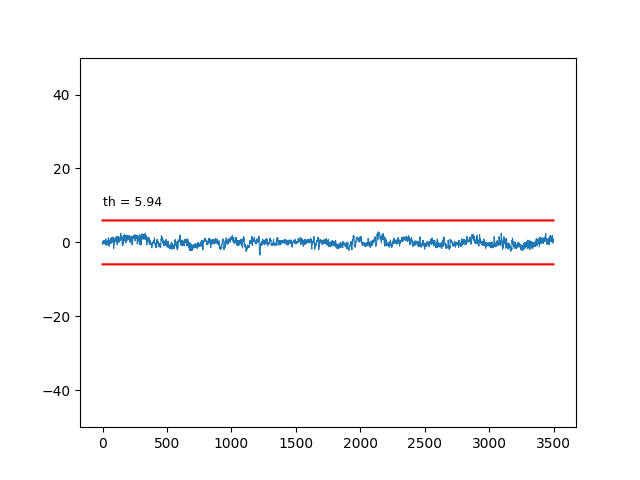

In [80]:
%matplotlib ipympl
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 10**(-5) # error rate
sigma = 1 - (1 - alpha)**(1/samples)
th = norm.ppf(1 - sigma/2) # we adapt the threshold depending on number of samples
t_val = ttest_ind(traces_1, traces_2, axis=0, equal_var=False)[0]
plt.close()
plt.plot(t_val[0:], linewidth=0.75)
plt.plot([th]*scope.adc.samples, color = 'r')
plt.plot([-th]*scope.adc.samples, color='r')
y_offset = 0.5 * th  
plt.text(
    2,                  
    th + y_offset,
    f"th = {th:.2f}",
    color='black',
    fontsize=9,
    verticalalignment='bottom'
)
plt.ylim(-50, 50)
plt.show()

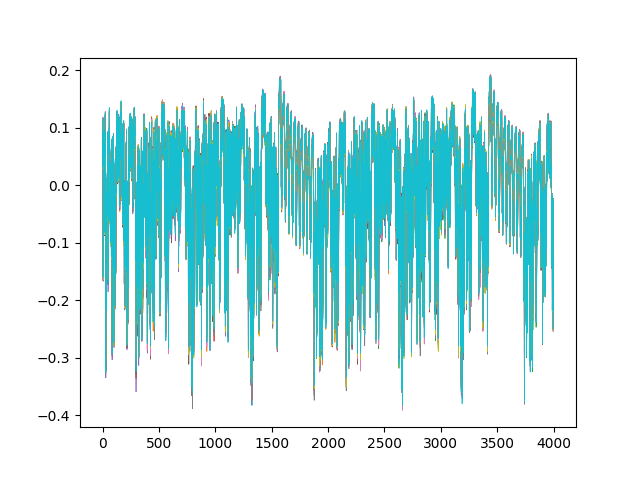

In [64]:
%matplotlib ipympl
import matplotlib.pyplot as plt

plt.close()
for t in traces_1[:10]:
    plt.plot(t[:], linewidth=0.5)
plt.show()

In [81]:
target.dis()
scope.dis()

True